# **Fourier Features Network**

Following example from Tancik et al.

In [ ]:
!pip install imageio-ffmpeg

In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio

# Enable TensorFlow's NumPy behavior
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Set random seed for reproducibility
tf.random.set_seed(0)


# **Set up data**

<ipython-input-17-98ada532221e>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


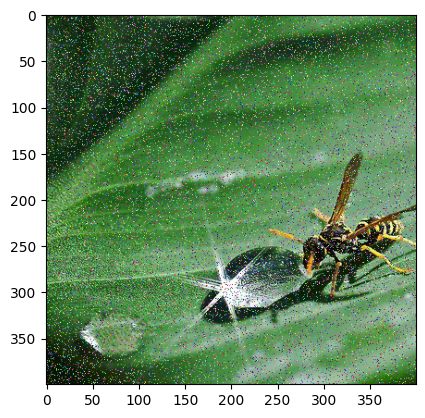

In [17]:
# Download image, take a square crop from the center
image_url = 'https://onlinepngtools.com/images/examples-onlinepngtools/wasp-on-leaf-with-noise.png'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 200
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2, ::2], img[::2, ::2]]


# **Model and Training FFN**

Model based off a coordinate-based multilayer perceptron. Figure below presents model architecture at a high level. For each input $(x,y)$, the model predicts associated $(r,g,b)$ values.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)



# **Build Fourier Feature Mapping**

From Tancik et al. the following mapping is used.

- $\gamma(\mathbf{v}) = \left[ a_{1} \cos(2 π \mathbf{b}_{1}^\mathbf{T} \mathbf{v}),a_{1} \sin(2 π \mathbf{b}_{1}^\mathbf{T} \mathbf{v}),...,a_{m} \cos(2 π \mathbf{b}_{m}^\mathbf{T} \mathbf{v}),a_{m} \sin(2 π \mathbf{b}_{m}^\mathbf{T} \mathbf{v})\right]$

For simplicity and comparison, only no mapping, simple mapping, and Guassian mapping will be used

No mapping:
- $\gamma(\mathbf{v}) = \mathbf{v}$

Simple Mapping (Simply wraps coordinates around the circle):
- $\gamma(\mathbf{v}) = \left[\cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v})\right]^\mathrm{T}$

Gaussian:
- $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $N(0,\sigma^2)$

In [4]:
# Fourier feature mapping
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = (2.*np.pi*x) @ B.T
        return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)


In [5]:
def make_network(num_layers, num_channels):
    model = tf.keras.Sequential()
    for _ in range(num_layers-1):
        model.add(tf.keras.layers.Dense(num_channels, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
    return model

def model_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def model_psnr(y_true, y_pred):
    mse = model_loss(y_true, y_pred)
    return -10.0 * tf.math.log(mse) / tf.math.log(10.0)


In [6]:
#Train model with given hyperparameters and data
def train_model(network_size, learning_rate, iters, B, train_data, test_data):
    x_train, y_train = train_data
    x_test, y_test = test_data

    model = make_network(*network_size)
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    x_train_mapped = input_mapping(x_train, B)
    x_test_mapped = input_mapping(x_test, B)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []

    for i in tqdm(range(iters)):
        with tf.GradientTape() as tape:
            y_pred = model(x_train_mapped)
            loss = model_loss(y_train, y_pred)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if i % 100 == 0 or i == iters-1:
            y_train_pred = model(x_train_mapped)
            y_test_pred = model(x_test_mapped)

            train_psnr = model_psnr(y_train, y_train_pred).numpy()
            test_psnr = model_psnr(y_test, y_test_pred).numpy()

            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            pred_imgs.append(y_test_pred.numpy().reshape(x_test.shape[0], x_test.shape[1], 3))

    return {
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': pred_imgs,
        'xs': list(range(0, iters, 100)) + [iters-1]
    }


In [18]:
network_size = (4, 400)
learning_rate = 1e-3
iters = 2000
mapping_size = 400
B_dict = {}

# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = tf.random.normal((mapping_size, 2))
for scale in [1., 5., 10.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

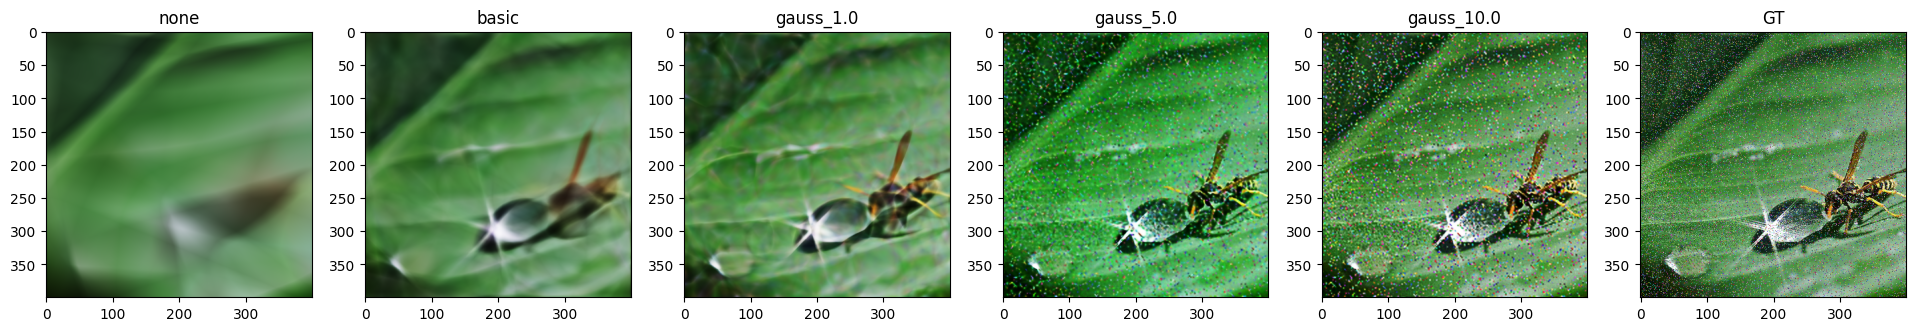

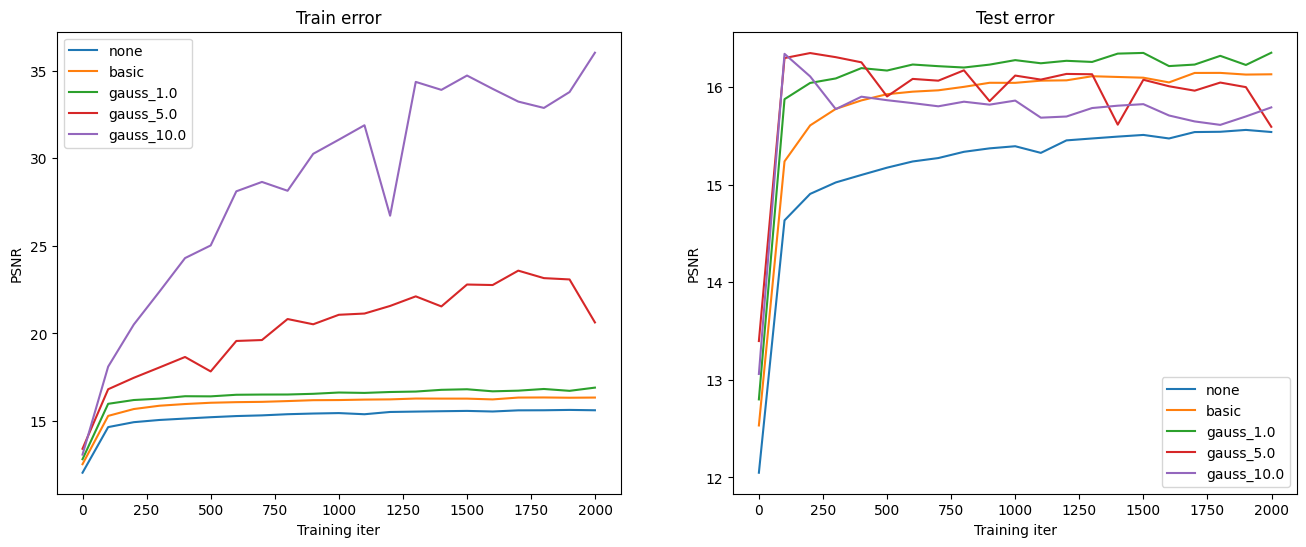

In [19]:
# Show final network outputs
plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves
plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()
